In [218]:
%pip install scikit-image --quiet
%pip install numpy --quiet
%pip install matplotlib --quiet
%pip install scipy --quiet
%pip install opencv-python --quiet
%pip install opencv-python-headless --quiet
%pip install opencv-contrib-python --quiet
%pip install scikit-learn --quiet
%pip install seaborn --quiet

]4;0;#000000\]4;1;#FFFFFF\]4;2;#CCCCCC\]4;3;#8f8f8f\]4;4;#FFFFFF\]4;5;#111111\]4;6;#CCCCCC\]4;7;#FFFFFF\]4;8;#404040\]4;9;#CCCCCC\]4;10;#FFFFFF\]4;11;#909090\]4;12;#CCCCCC\]4;13;#808080\]4;14;#CCCCCC\]4;15;#FFFFFF\]10;#FFFFFF\]11;[100]#000000\]12;#FFFFFF\]13;#FFFFFF\]17;#FFFFFF\]19;#000000\]4;232;#FFFFFF\]4;256;#FFFFFF\]708;[100]#000000\
Note: you may need to restart the kernel to use updated packages.
]4;0;#000000\]4;1;#FFFFFF\]4;2;#CCCCCC\]4;3;#8f8f8f\]4;4;#FFFFFF\]4;5;#111111\]4;6;#CCCCCC\]4;7;#FFFFFF\]4;8;#404040\]4;9;#CCCCCC\]4;10;#FFFFFF\]4;11;#909090\]4;12;#CCCCCC\]4;13;#808080\]4;14;#CCCCCC\]4;15;#FFFFFF\]10;#FFFFFF\]11;[100]#000000\]12;#FFFFFF\]13;#FFFFFF\]17;#FFFFFF\]19;#000000\]4;232;#FFFFFF\]4;256;#FFFFFF\]708;[100]#000000\
Note: you may need to restart the kernel to use updated packages.
]4;0;#000000\]4;1;#FFFFFF\]4;2;#CCCCCC\]4;3;#8f8f8f\]4;4;#FFFFFF\]4;5;#111111

In [219]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage import filters

In [220]:
# Config
ORB_FEATURES = 5000 # Number of features to extract
KNN = 3 # Number of neighbors to use in KNN

ADD_VARIATION = True # Add variations to the dataset
ADD_ROTATION = True # Add rotated images to the dataset
ADD_FLIP = True # Add flipped images to the dataset
ADD_SCALE = True # Add scaled images to the dataset

data_train_dir = 'data/train' # Directory containing training data

# Directory containing handpicked examples that can stand as outliers
# These are used to do further testing on the model,
# besides the standard train/test split
data_test_dir = 'data/test' 

ALIGN_TEMPLATE_IDX = 0 # Index of the template image to align the dataset to

In [221]:
# Load the images and keep the folder name as the label
def load_images(folder, n=None):
    images = []
    labels = []
    for label in os.listdir(folder):
        for filename in os.listdir(os.path.join(folder, label)):
            img = cv2.imread(os.path.join(folder, label, filename))
            if img is not None:
                images.append(img)
                labels.append(label)
            
            if n is not None and len(images) >= n:
                break
    return images, labels

images, labels = load_images(data_train_dir)

In [222]:
# ensure that there are no duplicates // count
for i in range(len(images)):
    for j in range(i+1, len(images)):
        if np.array_equal(images[i], images[j]):
            print(i, j)
            print(labels[i], labels[j])
            print(np.array_equal(images[i], images[j]))
            print('---')

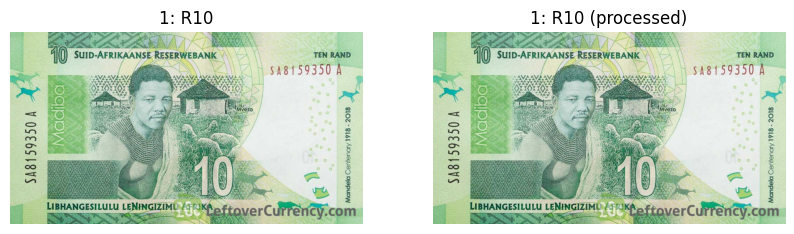

In [223]:
# helper function to display images
def display( l_images, r_images, l_labels,r_labels=None, display_images=None):
    if r_labels is None:
        r_labels = l_labels
    if display_images is None:
        display_images = range(len(l_images))
    for i in display_images:
        f, axarr = plt.subplots(1, 2, figsize=(10, 5))
        axarr[0].imshow(cv2.cvtColor(l_images[i], cv2.COLOR_BGR2RGB))
        axarr[0].set_title(str(i+1) + ': ' + l_labels[i])
        axarr[0].axis('off')
        axarr[1].imshow(cv2.cvtColor(r_images[i], cv2.COLOR_BGR2RGB))
        axarr[1].set_title(str(i+1) + ': ' + r_labels[i] + ' (processed)')
        axarr[1].axis('off')
        plt.show()
display(images, images, labels, labels, [0])

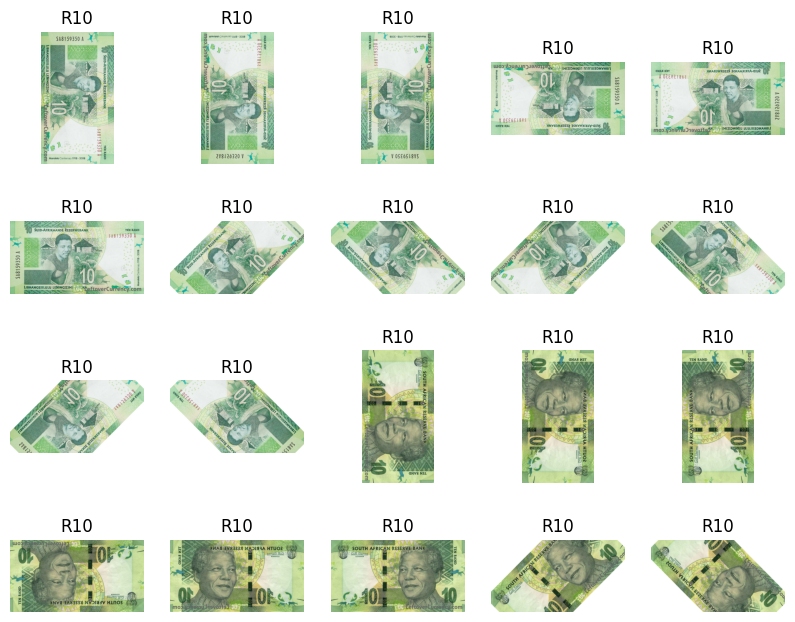

In [224]:
# Add variations to the dataset
def variants(img):
    if not ADD_VARIATION:
        return [img]
    variants = []
    angles = [0,cv2.ROTATE_180]
    flips = [0, 1]
    diagonal_angles = [45, -45]
    for angle in angles:
        var = cv2.rotate(img, angle)
        variants.append(var)
        for flip in flips:
            var = cv2.flip(var, flip)
            variants.append(var)
    
    # add rotated images
    for angle in diagonal_angles:
        M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), angle, 1)
        var = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), borderValue=(255, 255, 255))
        variants.append(var)
        for flip in flips:
            var = cv2.flip(var, flip)
            variants.append(var)
    
    # rm duplicates
    new_variants = []
    for i in range(len(variants)):
        for j in range(0, len(new_variants)):
            if np.array_equal(variants[i], new_variants[j]):
                break
        else:
            new_variants.append(variants[i])
    return new_variants



variant_images = []
variant_labels = []
for i in range(len(images)):
    for img in variants(images[i]):
        variant_images.append(img)
        variant_labels.append(labels[i])

# plot the first image and its variants in a small grid
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(5, 5, i+1)
    plt.imshow(cv2.cvtColor(variant_images[i], cv2.COLOR_BGR2RGB))
    plt.title(variant_labels[i])
    plt.axis('off')
plt.show()

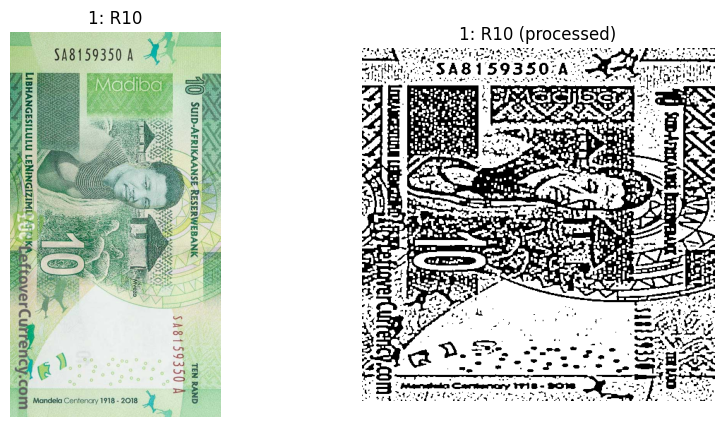

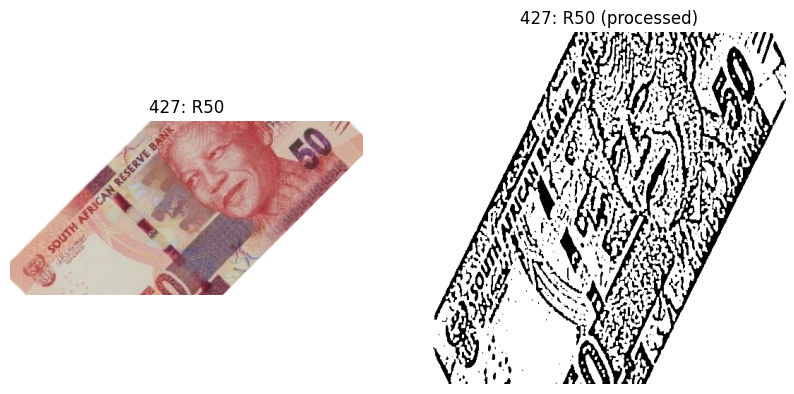

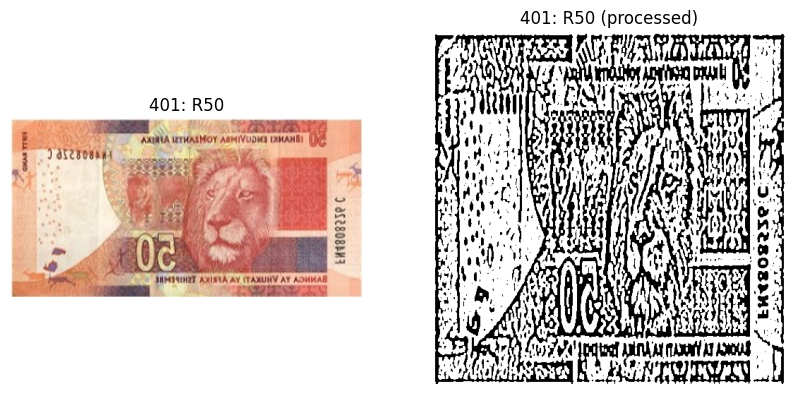

In [225]:
# Preprocess the images
def preprocess(img):
    img = cv2.resize(img, (500, 500))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # enhance morphological operations
    # kernel = np.ones((1,1),np.uint8)
    # img = cv2.erode(img, kernel, iterations = 1)
    kernel = np.ones((3,3),np.uint8)
    # img = cv2.dilate(img, kernel, iterations = 1)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    
    return img

preprocessed_images = [preprocess(img) for img in variant_images]

display(variant_images, preprocessed_images, variant_labels, variant_labels, [0, 426, 400])


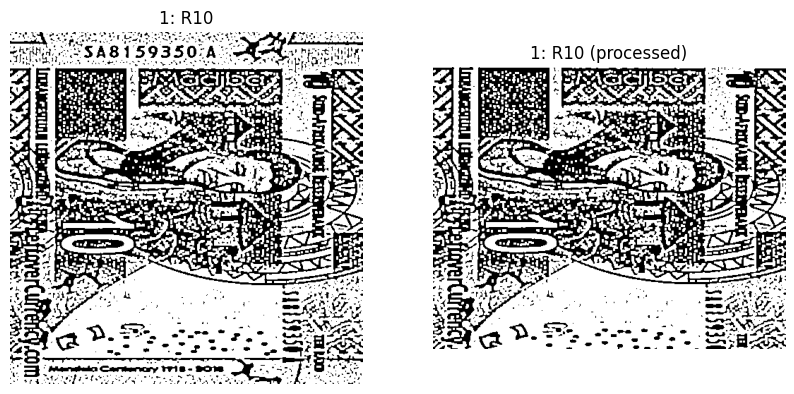

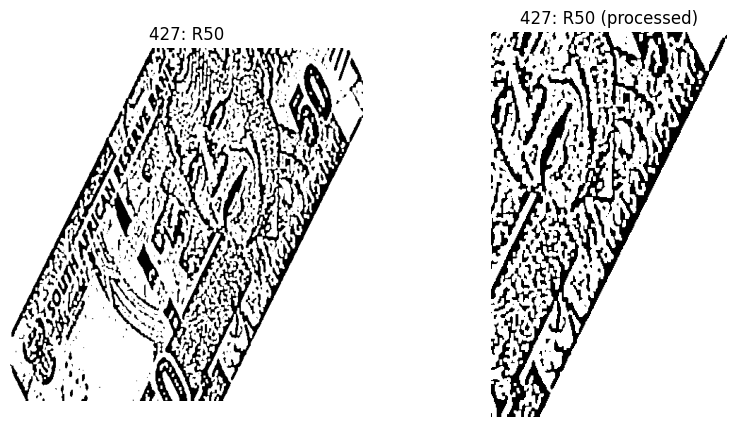

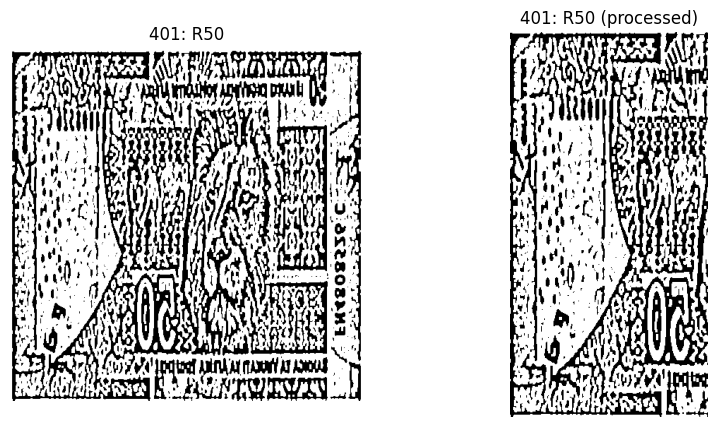

In [226]:
# align the images
def contour_segmentation(img):
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # find the contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # find the largest contour
    max_area = 0
    max_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_contour = contour
    # find the bounding rectangle
    x, y, w, h = cv2.boundingRect(max_contour)
    # crop the image  into rect
    img = img[y:y+h, x:x+w]
    # img = img[y:y+(h if h < w else w), x:x+(h if h < w else w)]
    return img

def grab_cut(img):

    # remove alpha channel
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    # create a mask
    mask = np.zeros(img.shape[:2], np.uint8)

    # define the background and foreground models
    bgdModel = np.zeros((1, 65), np.float64)

    fgdModel = np.zeros((1, 65), np.float64)

    # define the rectangle
    perc = 0.1
    padX = int(perc * img.shape[0])
    padY = int(perc * img.shape[1])

    rect = (padX, padY, img.shape[1] - 2 * padX, img.shape[0] - 2 * padY)
    # apply grabcut
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    # create a mask with the probable foreground
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # apply the mask to the image
    img = img * mask2[:, :, np.newaxis]

    return img

aligned_images = [contour_segmentation(img) for img in preprocessed_images]
# aligned_images = [grab_cut(img) for img in preprocessed_images]
display(preprocessed_images, aligned_images, variant_labels, variant_labels, [0, 426, 400])

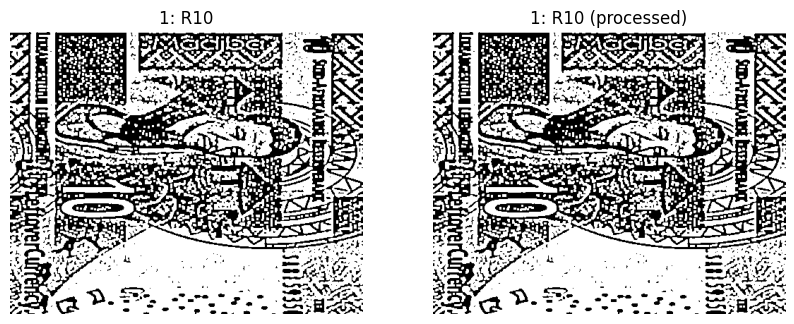

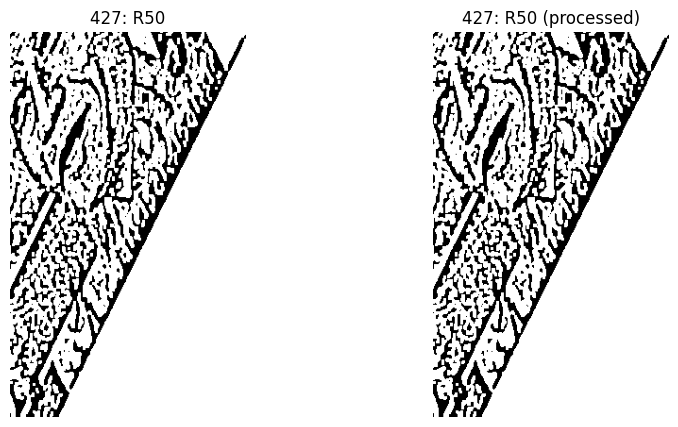

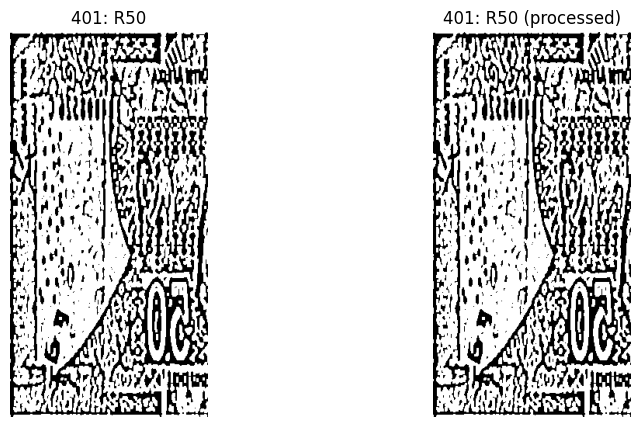

In [227]:
# orientation so that the longest side is the width
def orientation(img):
    # return img if img.shape[0] < img.shape[1] else cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    return img

oriented = [orientation(img) for img in aligned_images]

display(aligned_images, oriented, variant_labels, variant_labels, [0, 426, 400])

In [244]:
# Feature extraction
def extract_features_orb(img, n_features=ORB_FEATURES):
    orb = cv2.ORB_create(n_features)
    keypoints, descriptors = orb.detectAndCompute(img, None)
    return keypoints, descriptors

def extract_features_sift(img):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return keypoints, descriptors

def extract_features_harris(img):
    # remove alpha channel
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    ret, dst = cv2.threshold(dst, 0.01 * dst.max(), 255, 0)
    dst = np.uint8(dst)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray, np.float32(centroids), (5, 5), (-1, -1), criteria)
    return corners

def extract_features_hog(img):
    hog = cv2.HOGDescriptor()
    h = hog.compute(img)
    return h

# keypoints, descriptors = zip(*[extract_features_orb(img) for img in oriented])
keypoints, descriptors = zip(*[extract_features_sift(img) for img in oriented])
# descriptors = [extract_features_harris(img) for img in oriented]
# keypoints = [extract_features_hog(img) for img in oriented]

# check if any features were found
for i in range(len(descriptors)):
    if descriptors[i] is None:
        print('No features found for image', i)
        plt.imshow(cv2.cvtColor(aligned_images[i], cv2.COLOR_BGR2RGB))
        plt.title('No features found')
        plt.axis('off')
        plt.show()

print('Number of descriptors:',len(descriptors))
print('All shapes:', [d.shape for d in descriptors])

Number of descriptors: 864
All shapes: [(6340, 128), (6371, 128), (6367, 128), (6439, 128), (6471, 128), (6494, 128), (5676, 128), (5656, 128), (5681, 128), (5791, 128), (5790, 128), (5789, 128), (8084, 128), (8144, 128), (8117, 128), (8171, 128), (8128, 128), (8085, 128), (5835, 128), (5799, 128), (5851, 128), (5610, 128), (5648, 128), (5601, 128), (8084, 128), (8013, 128), (8001, 128), (8025, 128), (8026, 128), (8104, 128), (6704, 128), (6685, 128), (6685, 128), (6783, 128), (6763, 128), (6768, 128), (6678, 128), (6716, 128), (6682, 128), (6857, 128), (6840, 128), (6876, 128), (4006, 128), (4053, 128), (4028, 128), (4846, 128), (4855, 128), (4898, 128), (4789, 128), (4765, 128), (4784, 128), (4938, 128), (4958, 128), (4946, 128), (3260, 128), (3259, 128), (3302, 128), (2811, 128), (2862, 128), (2862, 128), (6148, 128), (6167, 128), (6080, 128), (6104, 128), (6047, 128), (5999, 128), (1335, 128), (1310, 128), (1313, 128), (2190, 128), (2186, 128), (2170, 128), (4414, 128), (4403, 128)

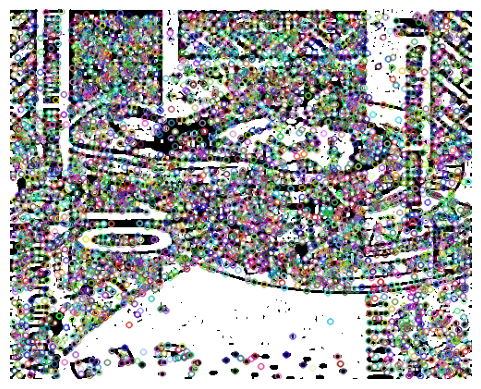

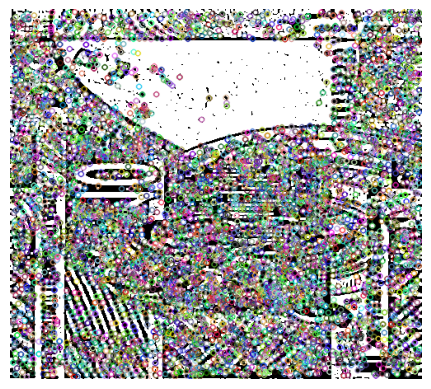

In [245]:
# display keypoints
def display_keypoints(img, keypoints):
    img = cv2.drawKeypoints(img, keypoints, None)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

display_keypoints(oriented[0], keypoints[0])
display_keypoints(oriented[25], keypoints[25])

In [246]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=1000)
kmeans.fit(np.vstack(descriptors))

# save the kmeans model
import pickle
with open('kmeans.pkl', 'wb') as f:
    pickle.dump(kmeans, f)


In [247]:
# bag of visual words
def bag_of_words(descriptors, kmeans):
    histogram = np.zeros(kmeans.n_clusters)
    if descriptors is not None:
        clusters = kmeans.predict(descriptors)
        for cluster in clusters:
            histogram[cluster] += 1
    return histogram

bovw = np.array([bag_of_words(d, kmeans) for d in descriptors])
bovw.shape

(864, 1000)

In [248]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bovw, variant_labels, test_size=0.2, random_state=42, stratify=variant_labels)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((691, 1000), (173, 1000), 691, 173)

Accuracy: 0.8670520231213873
              precision    recall  f1-score   support

         R10       0.94      0.85      0.89        34
        R100       0.77      0.89      0.83        38
         R20       0.92      0.73      0.81        33
        R200       0.89      0.91      0.90        34
         R50       0.86      0.94      0.90        34

    accuracy                           0.87       173
   macro avg       0.88      0.87      0.87       173
weighted avg       0.87      0.87      0.87       173



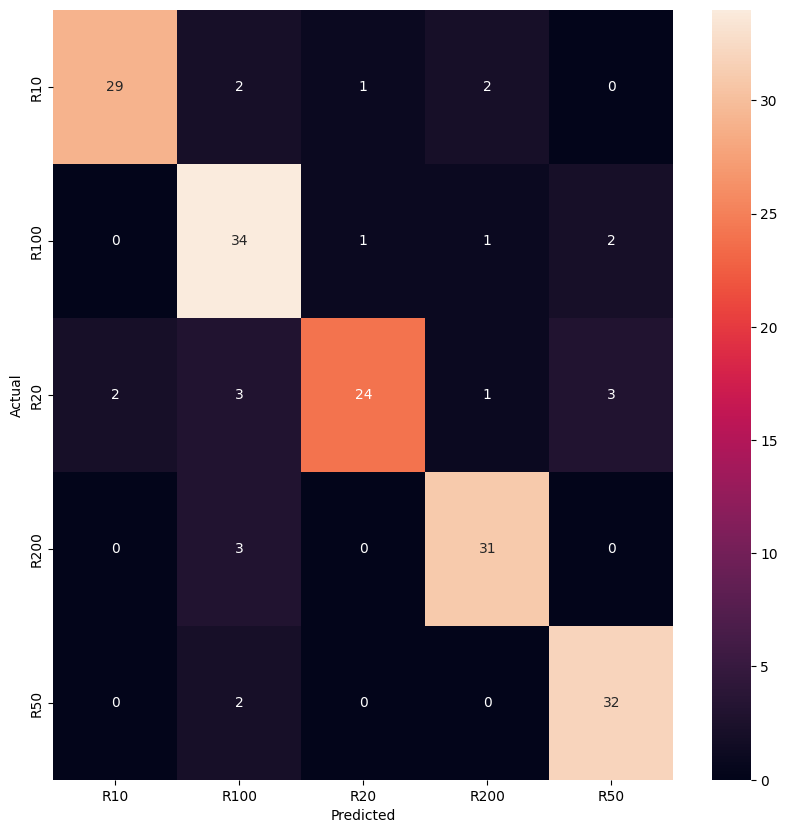

['rf.pkl']

In [254]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)





import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# save the model
import joblib
joblib.dump(rf, 'rf.pkl')




Accuracy: 0.9364161849710982
              precision    recall  f1-score   support

         R10       1.00      0.97      0.99        34
        R100       0.89      0.89      0.89        38
         R20       0.97      0.97      0.97        33
        R200       0.91      0.91      0.91        34
         R50       0.91      0.94      0.93        34

    accuracy                           0.94       173
   macro avg       0.94      0.94      0.94       173
weighted avg       0.94      0.94      0.94       173



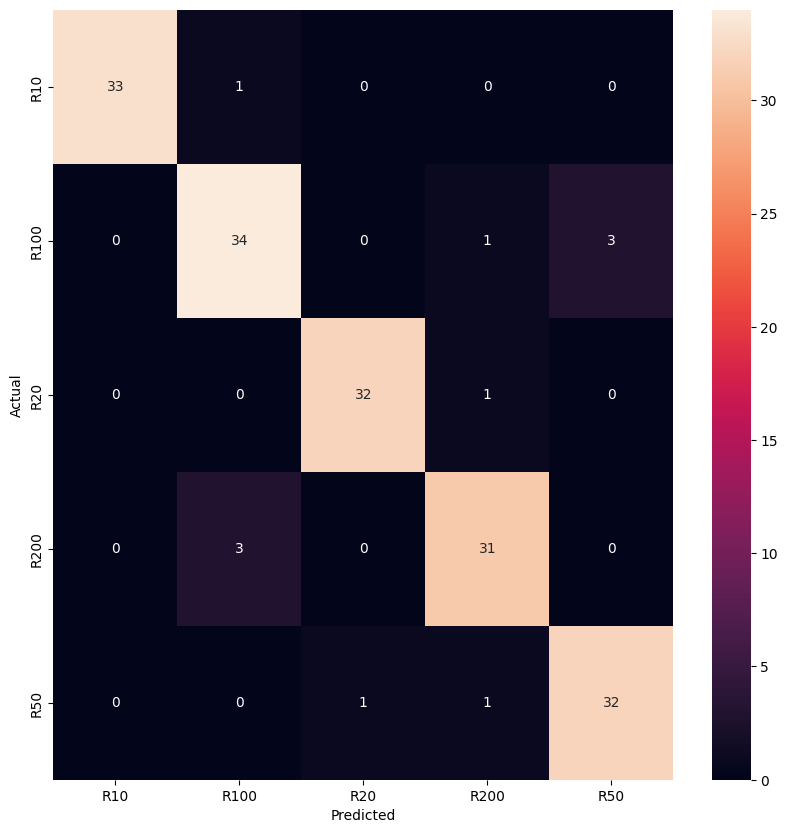

['svc.pkl']

In [255]:
# SVM
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# save the model
joblib.dump(svm, 'svc.pkl')

Accuracy: 0.9942196531791907
              precision    recall  f1-score   support

         R10       1.00      1.00      1.00        34
        R100       1.00      0.97      0.99        38
         R20       0.97      1.00      0.99        33
        R200       1.00      1.00      1.00        34
         R50       1.00      1.00      1.00        34

    accuracy                           0.99       173
   macro avg       0.99      0.99      0.99       173
weighted avg       0.99      0.99      0.99       173



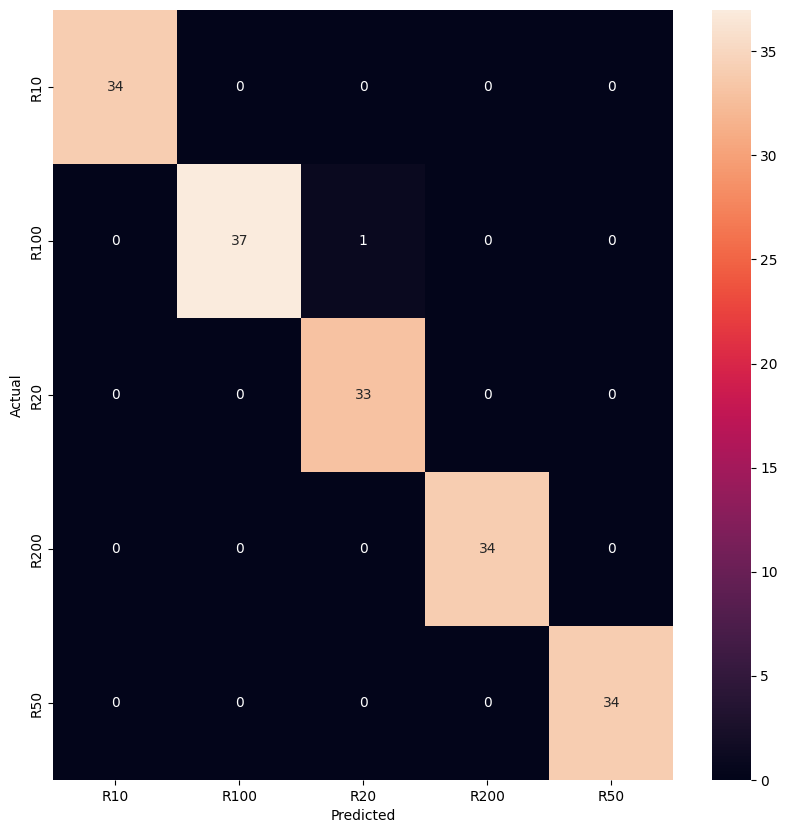

['knn.pkl']

In [256]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# save the model
joblib.dump(knn, 'knn.pkl')


Accuracy: 0.2
Accuracy: 0.13333333333333333
Accuracy: 0.26666666666666666


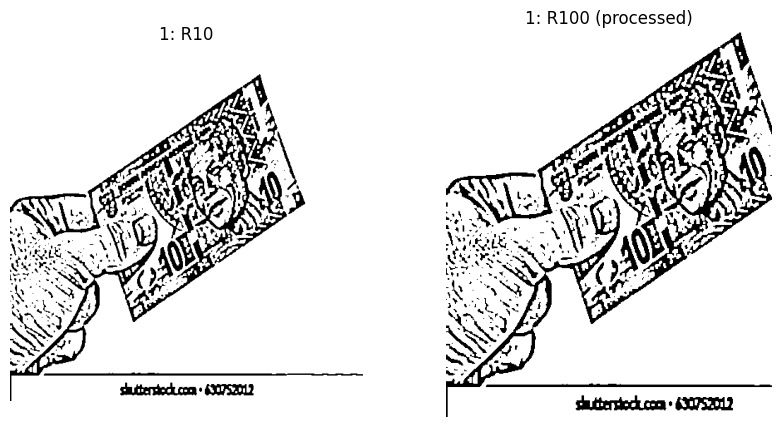

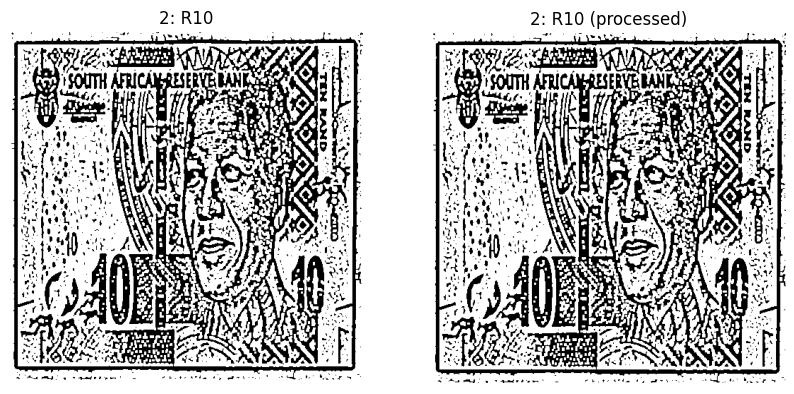

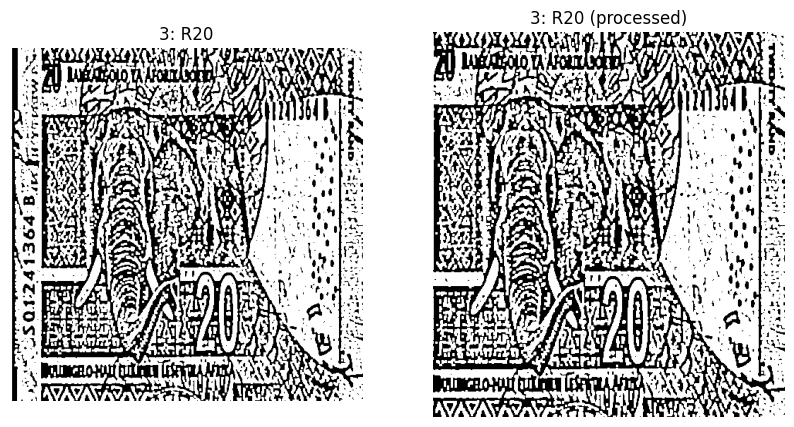

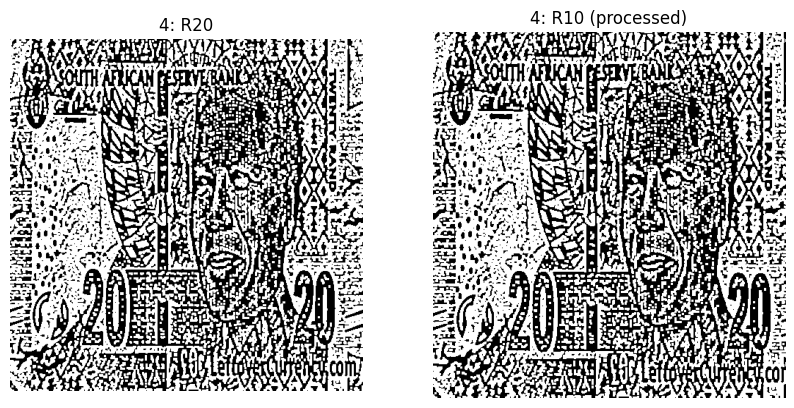

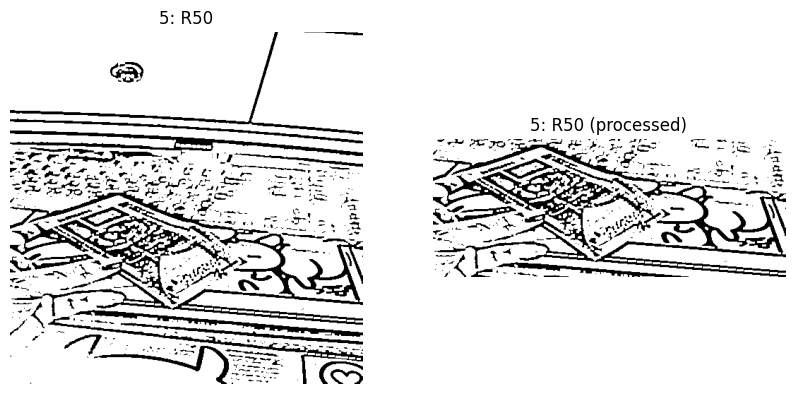

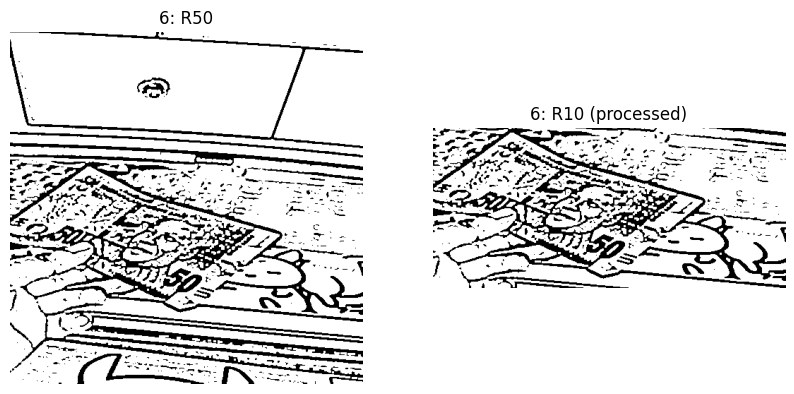

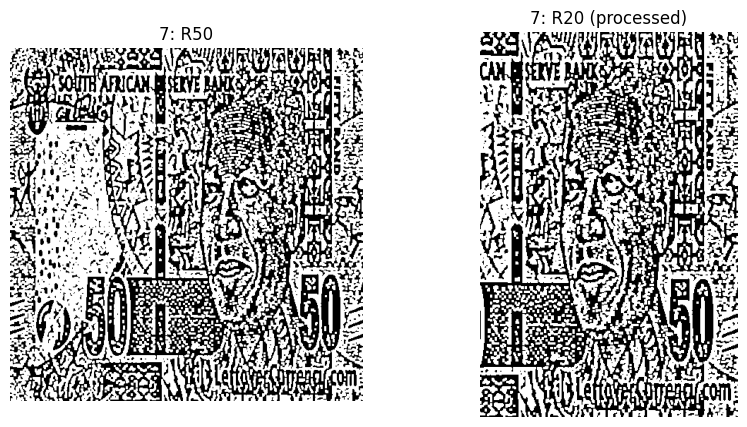

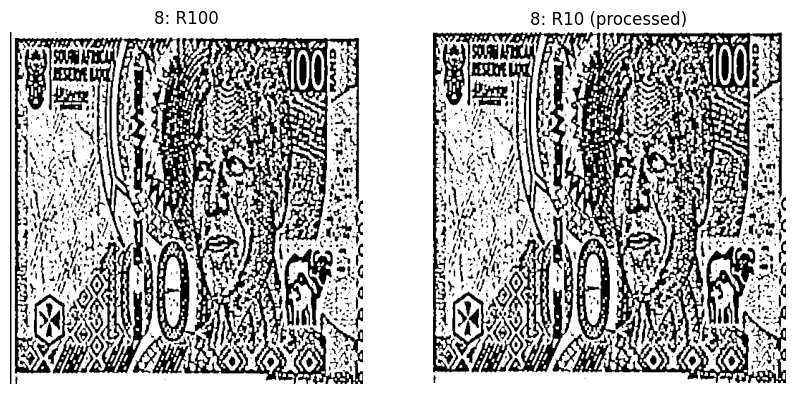

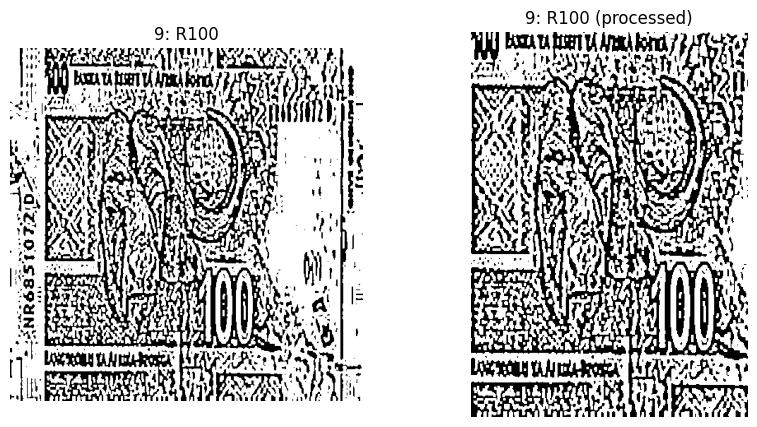

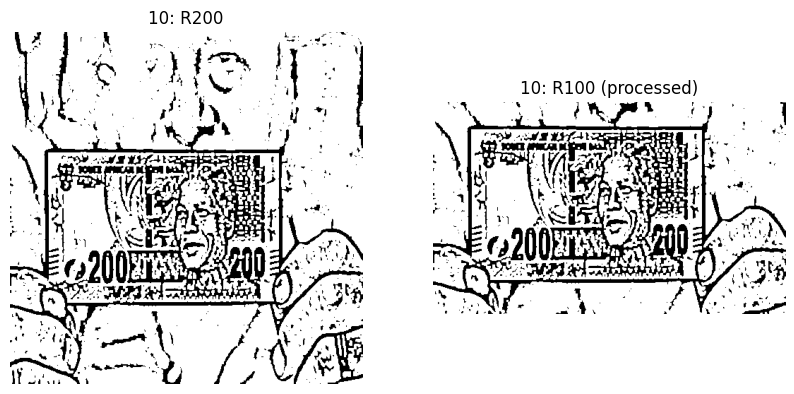

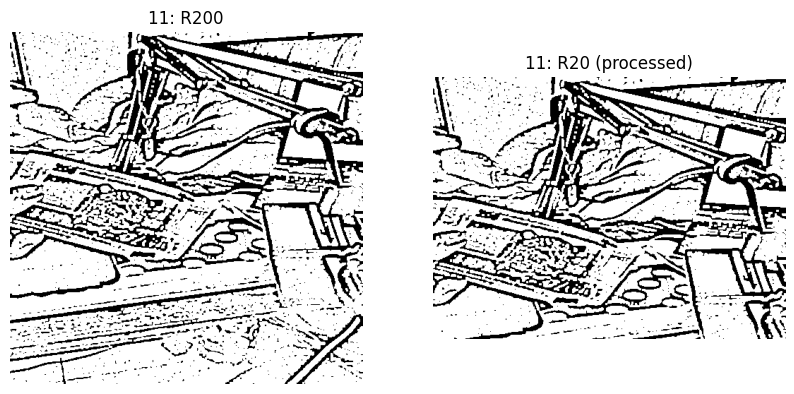

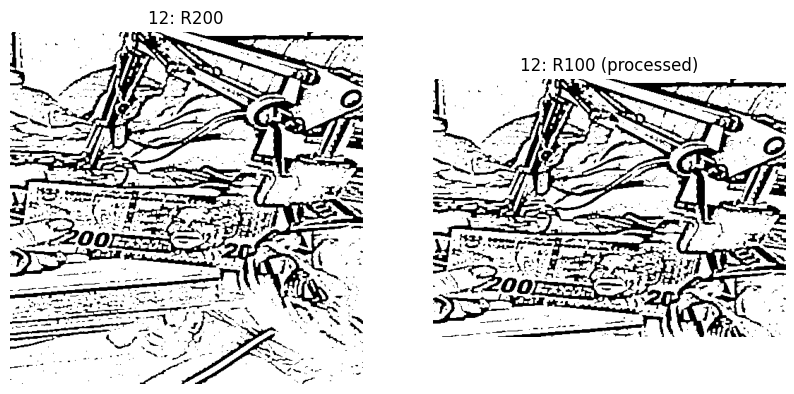

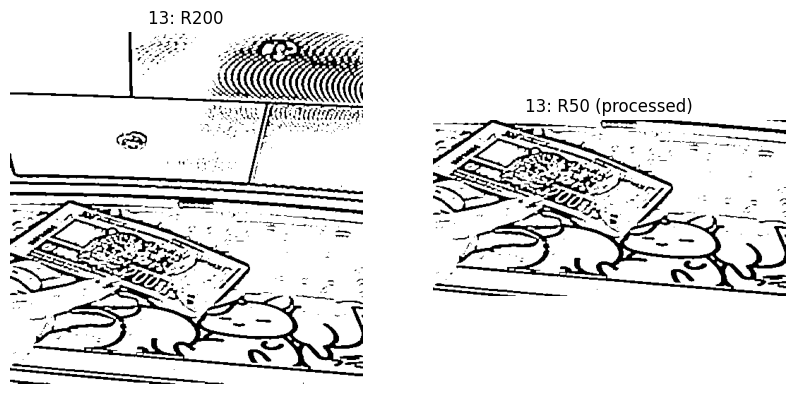

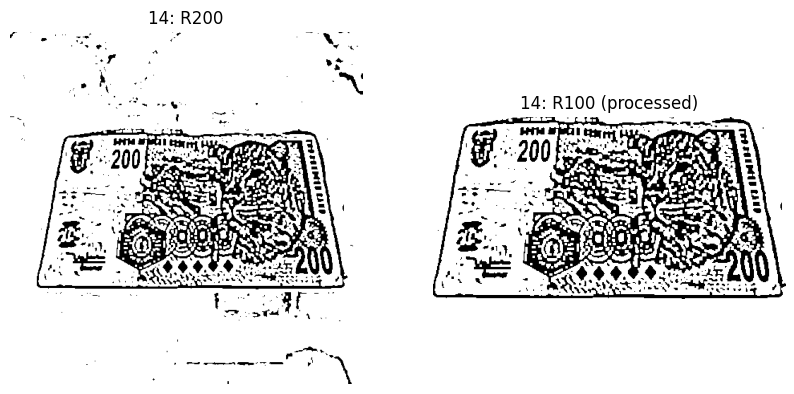

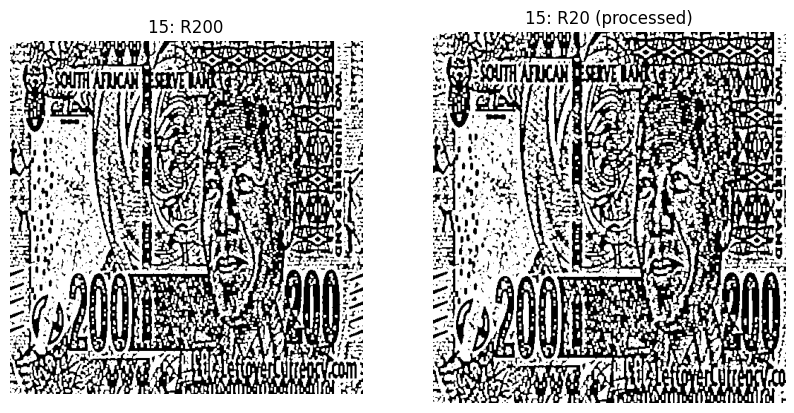

In [258]:
# additional more complex testing
# some very specific examples that are difficult to classify
test_images, test_labels = load_images(data_test_dir)
preprocessed_test_images = [preprocess(img) for img in test_images]
aligned_test_images = [contour_segmentation(img) for img in preprocessed_test_images]
oriented_test_images = [orientation(img) for img in aligned_test_images]
# keypoints_test, descriptors_test = zip(*[extract_features_orb(img) for img in oriented_test_images])
keypoints_test, descriptors_test = zip(*[extract_features_sift(img) for img in oriented_test_images])
# descriptors_test = [extract_features_harris(img) for img in oriented_test_images]
# bovw_test = np.array([bag_of_words(d, kmeans) for d in descriptors_test])
y_pred = rf.predict(bovw_test)
print('Accuracy:', accuracy_score(test_labels, y_pred))

y_pred = svm.predict(bovw_test)
print('Accuracy:', accuracy_score(test_labels, y_pred))

y_pred = knn.predict(bovw_test)
print('Accuracy:', accuracy_score(test_labels, y_pred))

# print oriented_test_images
display(preprocessed_test_images, oriented_test_images, test_labels, y_pred)